# Style Transfer with Convolutional Neural Networks

In [1]:
import torchvision.models as models
from importlib import reload
import torch
import numpy as np
from torch.optim import LBFGS, SGD
import torch.nn as nn
from __future__ import print_function
import utils as U;reload(U)
from torch.autograd import Variable
import torch.optim as optim
import torch.autograd as autograd

import matplotlib.pyplot as plt
import pdb
import copy

%matplotlib inline

# Pretrained model and relevant indexes

In [2]:
vgg = models.vgg16(pretrained=True)

In [3]:
activation_indexes = [ i for i, layer in enumerate(vgg.features) if type(layer) == nn.ReLU ]
print(activation_indexes)

[1, 3, 6, 8, 11, 13, 15, 18, 20, 22, 25, 27, 29]


# Content Loss

In [4]:
class ContentLoss(nn.Module):
    def __init__(self, weight, target):
        super(ContentLoss, self).__init__()        
        self.target = target.detach()
        self.weight = weight
        self.loss_fn = nn.MSELoss()
    
    def forward(self, input):
        self.loss = self.loss_fn(input, self.target)
        self.output = input.clone()
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss


# Style Loss

In [5]:
class GramMatrix(nn.Module):
    def forward(self, input):
        batch_size, height, width, chan = input.size()
        flattened_channels = input.view(batch_size * chan, width * height)
        g_matrix = torch.mm(flattened_channels, flattened_channels.t())
        return g_matrix.div(flattened_channels.nelement())

class StyleLoss(nn.Module):
    def __init__(self, weight, target):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.loss_fn = nn.MSELoss()
    
    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.loss_fn(self.G, self.target)
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss     

# Building Style Transfer model

In [6]:
def build_model(cnn, content_layers, style_layers, content_image, style_image):
    content_losses = []
    style_losses = []
    model = nn.Sequential()
    cnn = copy.deepcopy(cnn).cuda()
    gram = GramMatrix()
    style_indexes = style_layers.keys()
    content_indexes = content_layers.keys()
    for index, layer in enumerate(cnn.features):
        layer_set = False            
        if type(layer) is nn.ReLU:
            layer_set = True
            model.add_module("layer_{}_relu".format(index), layer)
            
            if  index in style_indexes:
                style_target = model(style_image.unsqueeze(0)).clone()
                style_loss = StyleLoss(style_layers[index], gram(style_target))
                style_losses.append(style_loss)
                model.add_module("layer_{}_style_loss_relu".format(index), style_loss)
            
            if index in content_indexes:
                content_target = model(content_image.unsqueeze(0)).clone()
                content_loss = ContentLoss(content_layers[index], content_target)
                content_losses.append(content_loss)
                model.add_module("layer_{}_content_loss_relu".format(index), content_loss)           

        if type(layer) is nn.MaxPool2d:
            #replace max pooling with avg pooling to retain more information
            layer_set = True
            avg_pool = nn.AvgPool2d(kernel_size=layer.kernel_size, stride=layer.stride, padding = layer.padding)
            model.add_module("layer_{}".format(index), avg_pool)
            
        if not layer_set:
            model.add_module("layer_{}".format(index), layer)
    model = model.cuda()
    for p in model.parameters():
        p.requires_grad = False
    return model, content_losses, style_losses

In [7]:
def run_epochs(mmmodel, count, img, optimizer, s_losses, c_losses, print_every=100):
    elapsed_epochs = 0
    for i in range(count):
        img.data.clamp_(0,1)
        mmmodel.zero_grad()
        optimizer.zero_grad()
        elapsed_epochs += 1
        prediction = img.unsqueeze(0)
        
        mmmodel(prediction)
        
        s_loss = sum([ s.backward() for s in s_losses ])
        c_loss = sum([ c.backward() for c in c_losses ])
#
        optimizer.step()
        style_loss =  s_loss.data[0]
        content_loss = c_loss.data[0]
        
        if i % print_every == 0:
            print("Epoch #{} Content Loss: {} Style Loss: {} Total Loss: {}".format(str(i), content_loss, style_loss, content_loss + style_loss ))
    img.data.clamp_(0,1)

In [8]:
def build_optimizer(starting_img, lr=1):
    img_param = nn.Parameter(starting_img)
    img_param = img_param.cuda().clone().detach()
    img_param.requires_grad = True
    optimizer = SGD([img_param], lr=lr)
    return img_param, optimizer


# Experiments

In [38]:
content_layers = {
    1: 1,
    3: 1,
    6: 1,
    8: 1,
    11: 1
}

style_layers = {
    1: 500,
    3: 700,
    6: 900,
    8: 1200,
    11: 2500
}


In [10]:
from torchvision.transforms import ToPILImage
unloader = ToPILImage()
def unload(img):
    img = img.data
    img = img.clone().cpu()
    img = unloader(img)
    return img

def show_results(content_image, style_image, img):
    content_img = unload(content_image)
    style_img = unload(style_image)
    result_img = unload(img)
    
    f, axis = plt.subplots(1,3)
    f.set_size_inches(20, 5)
    axis[0].imshow(content_img)
    axis[1].imshow(style_img)
    axis[2].imshow(result_img)    

## #1

In [11]:
style_image  = Variable(U.get_image(9, 84)).cuda()
content_image = Variable(U.get_image(4, None, 112)).cuda()

model, c_losses, s_losses = build_model(vgg, content_layers, style_layers, content_image, style_image)
img_param, optimizer = build_optimizer(content_image.data, lr=1)

In [12]:
run_epochs(model, 5000, img_param, optimizer, s_losses, c_losses, print_every=1000)

Epoch #1000 Content Loss: 0.0 Style Loss: 17.785572052001953 Total Loss: 17.785572052001953
Epoch #2000 Content Loss: 0.8434118032455444 Style Loss: 0.46526288986206055 Total Loss: 1.308674693107605
Epoch #3000 Content Loss: 0.8575762510299683 Style Loss: 0.37885379791259766 Total Loss: 1.236430048942566
Epoch #4000 Content Loss: 0.8608453273773193 Style Loss: 0.34583091735839844 Total Loss: 1.2066762447357178
Epoch #5000 Content Loss: 0.861268937587738 Style Loss: 0.3292384743690491 Total Loss: 1.190507411956787


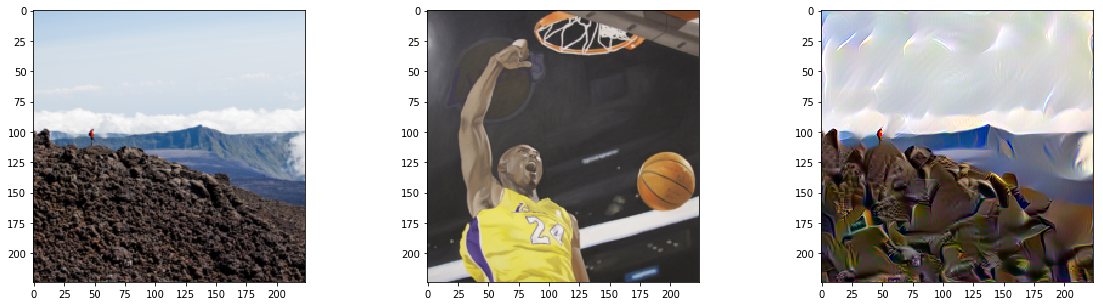

In [13]:
show_results(content_image, style_image, img_param)

# #2

In [41]:
style_image  = Variable(U.get_image(9, 84)).cuda()
content_image = Variable(U.get_image(3, None)).cuda()
print(content_image.size())
model, c_losses, s_losses = build_model(vgg, content_layers, style_layers, content_image, style_image)
img_param, optimizer = build_optimizer(content_image.data, lr=1)

torch.Size([3, 224, 224])


In [42]:
run_epochs(model, 15000, img_param, optimizer, s_losses, c_losses, print_every=2500)

Epoch #1000 Content Loss: 0.0 Style Loss: 9.281644821166992 Total Loss: 9.281644821166992
Epoch #3500 Content Loss: 0.6241722702980042 Style Loss: 0.29660218954086304 Total Loss: 0.9207744598388672
Epoch #6000 Content Loss: 0.6233413219451904 Style Loss: 0.2699497938156128 Total Loss: 0.8932911157608032
Epoch #8500 Content Loss: 0.6212682723999023 Style Loss: 0.25881749391555786 Total Loss: 0.8800857663154602
Epoch #11000 Content Loss: 0.6193068623542786 Style Loss: 0.25205546617507935 Total Loss: 0.8713623285293579
Epoch #13500 Content Loss: 0.6178973913192749 Style Loss: 0.247653990983963 Total Loss: 0.8655513823032379


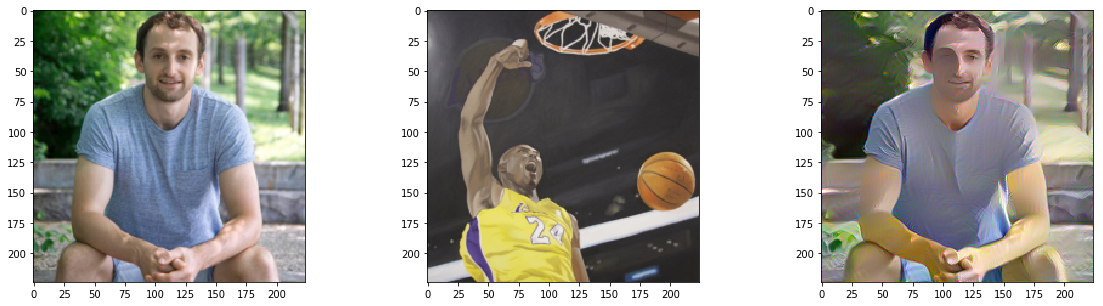

In [43]:
show_results(content_image, style_image, img_param)

# #3

In [44]:
style_image  = Variable(U.get_image(6, 54)).cuda()
content_image = Variable(U.get_image(1, 91, None)).cuda()
print(content_image.size())
print(style_image.size())
model, c_losses, s_losses = build_model(vgg, content_layers, style_layers, content_image, style_image)
img_param, optimizer = build_optimizer(content_image.data, lr=1)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [47]:
run_epochs(model, 3000, img_param, optimizer, s_losses, c_losses, print_every=1000)

Epoch #1000 Content Loss: 1.089164137840271 Style Loss: 0.25387418270111084 Total Loss: 1.3430383205413818
Epoch #2000 Content Loss: 1.085636019706726 Style Loss: 0.24618402123451233 Total Loss: 1.3318200409412384
Epoch #3000 Content Loss: 1.0829689502716064 Style Loss: 0.2413812279701233 Total Loss: 1.3243501782417297


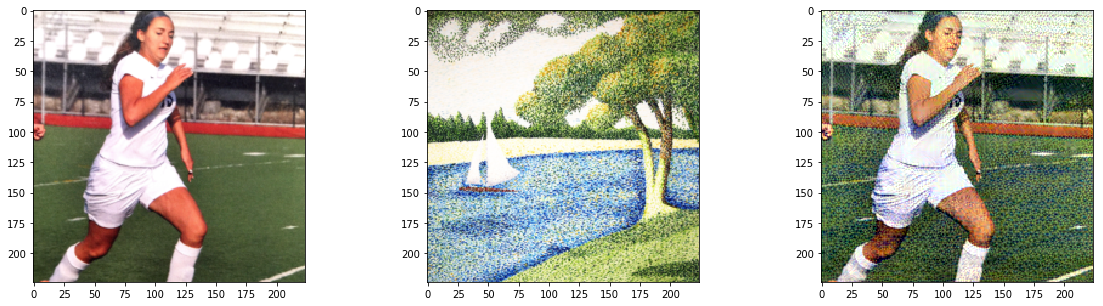

In [48]:
show_results(content_image, style_image, img_param)